<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/Drone%20Prediction/MobilenetV2_Model_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jul 24 06:03:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
sys.path.append('/content/gdrive/My Drive/Session2')
os.chdir('/content/gdrive/My Drive/Session2')

In [4]:
! pip install piexif
import piexif

In [5]:
 model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
#for name, param in model.named_parameters():
#    print(name)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
num_classes=4
model.classifier=nn.Linear(1280,num_classes,bias=True)

In [7]:
!pip install torchsummary
from torchsummary import summary
summary(model.to('cuda'),input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [8]:
!7z x '/content/gdrive/My Drive/Session2/Session 2 Dataset.7z' -o'/content/data/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Session2/                                            1 file, 2006710848 bytes (1914 MiB)

Extracting archive: /content/gdrive/My Drive/Session2/Session 2 Dataset.7z
--
Path = /content/gdrive/My Drive/Session2/Session 2 Dataset.7z
Type = 7z
Physical Size = 2006710848
Headers Size = 306080
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% 6 - Session 2 Dataset/FlyBirds Canada/000001.jpg                                                       0% 34 - Session 2 Dataset/FlyBirds Canada/000035.jpg

In [39]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [40]:
large_drones=[]
label=[]
bird_drones=[]
winged_drones=[]
drones=[]
import numpy as np
from PIL import Image

count=1  # to restrict the data to few thousand


# Getting the BG list and replicate each background to 4000 


for root_large_drones, dirs_large_drones, files_large_drones in os.walk("/content/data/Session 2 Dataset/Large QuadCopters/"):
   for name_large_drones in files_large_drones:
     check_for_Jpg=name_large_drones.split('.')
     if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
      
        p= Image.open(root_large_drones +'/'+ name_large_drones)
        if p.mode == 'RGB' :
         
         drones.append(root_large_drones +'/'+ name_large_drones)
         label.append(0)
     

for root_winged_drones, dirs_winged_drones, files_winged_drones in os.walk("/content/data/Session 2 Dataset/Winged Drones/"):
   for name_winged_drones in files_winged_drones:
     check_for_Jpg=name_winged_drones.split('.')
     if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
        p= Image.open(root_winged_drones +'/'+ name_winged_drones)
        if p.mode == 'RGB': 
      
         drones.append(root_winged_drones +'/'+ name_winged_drones) 
         label.append(1)  

for root_bird_drones, dirs_bird_drones, files_bird_drones in os.walk("/content/data/Session 2 Dataset/Flying Birds/"):
   for name_bird_drones in files_bird_drones:
      check_for_Jpg=name_bird_drones.split('.')
      if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
        p= Image.open(root_bird_drones +'/'+ name_bird_drones)
        if p.mode == 'RGB': 
                    
         drones.append(root_bird_drones +'/'+ name_bird_drones)   
         label.append(2)    

for root_bird_can_drones, dirs_bird_can_drones, files_bird_can_drones in os.walk("/content/data/Session 2 Dataset/FlyingBirds Canada/"):
   for name_bird_can_drones in files_bird_can_drones:
      check_for_Jpg=name_bird_can_drones.split('.')
      if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
        p= Image.open(root_bird_can_drones +'/'+ name_bird_can_drones)
        if p.mode == 'RGB':
        
         drones.append(root_bird_can_drones +'/'+ name_bird_can_drones)   
         label.append(2) 

for root_small_drones, dirs_small_drones, files_small_drones in os.walk("/content/data/Session 2 Dataset/Small QuadCopters/"):
   for name_small_drones in files_small_drones:
     check_for_Jpg=name_small_drones.split('.')
     if check_for_Jpg[-1].lower()=='jpg' or check_for_Jpg[-1].lower() =='jpeg':
        p= Image.open(root_small_drones +'/'+ name_small_drones)
        if p.mode == 'RGB':
          
           drones.append(root_small_drones +'/'+ name_small_drones)   
           label.append(3)      
 

In [41]:
tot_drones={}
tot_drones={'drones' : drones , 'labels' : label}


In [ ]:
len(tot_drones['drones'])

17217

In [ ]:
import cv2
for count in range(len(tot_drones['drones'])):
 p= Image.open(tot_drones['drones'][count])
"
 #k=p.mode
 #if k != 'RGB':
 # print(tot_drones['drones'][count])


In [ ]:
#print('No of data in large drones list:',   len(large_drones))
#print('No of data in winged drones list:',   len(winged_drones))
#print('No of data in bird list:',   len(bird_drones))

No of data in fgbg list: 502


In [ ]:
tot_drones['labels'][17000]

3

In [42]:

drones_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ColorJitter(brightness=0.20, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-30,30),fill=(0)),
                                       #transforms.Grayscale(),
                                       transforms.ToTensor(),
                                      
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])


In [43]:
import glob
from PIL import Image
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
#dataset=torchvision.datasets.DatasetFolder(tot_drones['drones'],loader=None, extensions=None, transform=drones_transform, target_transform=None, is_valid_file=None)

In [44]:
class Myclass(torch.utils.data.Dataset):
    def __init__ (self,tot_drones,total,transform=None):
       #super(depthmask, self).__init__()
       self.tot_drones = tot_drones
       self.total=total
       self.transform = transform
       

    def __getitem__ (self, idx): 
         drones_t = Image.open(self.tot_drones['drones'][idx]).convert('RGB')
         if self.transform:
           final_drones = self.transform[0](drones_t)
           sample = {'total_drones' : final_drones , 'labels' : self.tot_drones['labels'][idx] }
         return sample
    
    def __len__ (self):
       return (self.total)
  

In [45]:
#final_dataset=Myclass(bg_image_dataset,fgbg_image_dataset,mask_image_dataset,depth_image_dataset,transform=[fgbg_transform,bg_transform,mask_transform,depth_transform])
final_dataset=Myclass(tot_drones,len(tot_drones['drones']),transform=[drones_transform])
for i in range(len(final_dataset)):
    sample = final_dataset[i]
    print(i,'-large_drones:', sample['total_drones'].size())

    if i == 3:
        break

0 -large_drones: torch.Size([3, 224, 224])
1 -large_drones: torch.Size([3, 224, 224])
2 -large_drones: torch.Size([3, 224, 224])
3 -large_drones: torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
17217


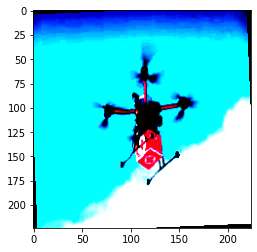

In [46]:
import numpy as np
plt.imshow((np.transpose((sample['total_drones'].cpu().detach().numpy()),(1,2,0))))
print((sample['labels']))
print(len(tot_drones['drones']))

In [47]:
SEED = 1
torch.cuda.empty_cache()
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED) 

train_dataset, valid_dataset = torch.utils.data.random_split(final_dataset, (12052, 5165))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=40,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=40,
                                         shuffle=False, num_workers=2)

CUDA Available? True


In [ ]:
img=next(iter(trainloader))

In [48]:
from tqdm import tqdm
loss_1=[]
loss_2=[]
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  cri = nn.CrossEntropyLoss()
  #cri=nn.MSELoss()
  for batch_idx, data in enumerate(pbar):
    # get samples
    data['total_drones'] = data['total_drones'].to(device)
    data['labels'] = data['labels'].to(device)


    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data['total_drones'])
    #y_pred = model(data['fgbg'])
   
    # Calculate loss

    loss=cri(y_pred,data['labels'])
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(data['labels'].view_as(pred)).sum().item()
    processed += len(data['total_drones'])
    
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    map=[]
    test_loss = 0
    correct = 0
    cri =  nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in test_loader:
            data['total_drones'] = data['total_drones'].to(device)
            data['labels'] = data['labels'].to(device)

            output= model(data['total_drones'])
            
            loss=cri(output,data['labels'])
          
            test_loss += loss.item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(data['labels'].view_as(pred)).sum().item()
    
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
  
   

In [49]:
from torch.optim.lr_scheduler import StepLR
#tqdm._instances.clear()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.90,weight_decay=0.001)
#optimizer=optim.Adam(model.parameters(), lr=0.055, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
scheduler=StepLR(optimizer,step_size=5,gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    scheduler.step()

  0%|          | 0/302 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.6934640407562256 Batch_id=301 Accuracy=71.78: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 3849/5165 (74.52%)

EPOCH: 1


Loss=0.5995232462882996 Batch_id=301 Accuracy=78.34: 100%|██████████| 302/302 [03:19<00:00,  1.52it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 3990/5165 (77.25%)

EPOCH: 2


Loss=0.6204912066459656 Batch_id=301 Accuracy=81.84: 100%|██████████| 302/302 [03:14<00:00,  1.55it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Accuracy: 4140/5165 (80.15%)

EPOCH: 3


Loss=0.7118157744407654 Batch_id=301 Accuracy=82.23: 100%|██████████| 302/302 [03:12<00:00,  1.57it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 4185/5165 (81.03%)

EPOCH: 4


Loss=0.4161261022090912 Batch_id=301 Accuracy=83.57: 100%|██████████| 302/302 [03:12<00:00,  1.57it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Accuracy: 4192/5165 (81.16%)

EPOCH: 5


Loss=0.3467036187648773 Batch_id=301 Accuracy=87.56: 100%|██████████| 302/302 [03:21<00:00,  1.50it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 4379/5165 (84.78%)

EPOCH: 6


Loss=0.2838068902492523 Batch_id=301 Accuracy=88.52: 100%|██████████| 302/302 [03:19<00:00,  1.52it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 4398/5165 (85.15%)

EPOCH: 7


Loss=0.29332807660102844 Batch_id=301 Accuracy=89.57: 100%|██████████| 302/302 [03:27<00:00,  1.45it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 4430/5165 (85.77%)

EPOCH: 8


Loss=0.04580758139491081 Batch_id=301 Accuracy=90.02: 100%|██████████| 302/302 [03:21<00:00,  1.50it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 4405/5165 (85.29%)

EPOCH: 9


Loss=0.2986890375614166 Batch_id=301 Accuracy=90.36: 100%|██████████| 302/302 [03:25<00:00,  1.47it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 4398/5165 (85.15%)

EPOCH: 10


Loss=0.2637843191623688 Batch_id=301 Accuracy=91.25: 100%|██████████| 302/302 [03:23<00:00,  1.48it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 4437/5165 (85.91%)

EPOCH: 11


Loss=0.08077219873666763 Batch_id=301 Accuracy=91.30: 100%|██████████| 302/302 [03:21<00:00,  1.50it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 4451/5165 (86.18%)

EPOCH: 12


Loss=0.0631377100944519 Batch_id=301 Accuracy=91.50: 100%|██████████| 302/302 [03:20<00:00,  1.51it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 4428/5165 (85.73%)

EPOCH: 13


Loss=0.2429211586713791 Batch_id=301 Accuracy=91.67: 100%|██████████| 302/302 [03:27<00:00,  1.45it/s]
  0%|          | 0/302 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 4437/5165 (85.91%)

EPOCH: 14


Loss=0.38809213042259216 Batch_id=301 Accuracy=91.53: 100%|██████████| 302/302 [03:22<00:00,  1.49it/s]



Test set: Average loss: 0.0100, Accuracy: 4417/5165 (85.52%)



In [50]:
data=(next(iter(testloader)))
out=model(data['total_drones'].to(device)) 

In [51]:
pred = out.argmax(dim=1, keepdim=True)

In [52]:
torch.save(model.state_dict(),'Mobilenet.pt')

In [ ]:
out